# Taylor test
This example shows how to do a Taylor test on the dipole problem, and the difference in
gradient/solution accuracy between the slack variable (exact) or log-sum-exp (approximate)
smoothing methods.

In [1]:
import time
import jax
import jax.numpy as jnp
import numpy as np
from jax import block_until_ready
from quadcoil import quadcoil
from quadcoil.quantity import f_B
from simsopt import load

In [2]:
# First, estimate a f_B target using a nescoil problem

In [3]:
# Define a dipole problem
winding_surface, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
mpol = 12
ntor = 12
separation = 0.1
f_B_target = 1e-3
unit_Phi = 1e5
unit_l1_Phi = 1e6

In [4]:
quadcoil_kwargs = {
    'nfp': plasma_surface.nfp,
    'stellsym': plasma_surface.stellsym,
    'plasma_coil_distance': separation,
    'mpol': mpol,
    'ntor': ntor,
    'plasma_mpol': plasma_surface.mpol,
    'plasma_ntor': plasma_surface.ntor,
    'net_poloidal_current_amperes': net_poloidal_current_amperes,
    'net_toroidal_current_amperes': 0.,
    'metric_name': ('f_max_Phi', 'f_B'),
    'objective_name': 'f_max_Phi', # Minimizing peak dipole density
    'objective_unit': unit_max_Phi, # under an f_B constraint
    'constraint_name': ('f_B',),
    'constraint_type': ('<=',),
    'constraint_unit': (f_B_target,),
    'constraint_value': np.array([f_B_target,]),
}

In [5]:
# Codes for running the Taylor test

# The index of the phi dof to test over
test_i = 0

def taylor_test(plasma_surface, quadcoil_kwargs, case_num=40):
    outdict_list = []
    plasma_dof_0_list = []
    time_quadcoil_list = []
    lam_list = []
    mu_list = []
    c_list = []
    qp_list = []
    phi_test_list = []
    for i in jnp.linspace(-0.05, 0.05, case_num):
        plasma_dof_i = np.array(plasma_surface.get_dofs()) # np.array(qp_temp.plasma_surface_temp.dofs.copy())
        plasma_dof_i[test_i] *= (1 + i)
        # Run QUADCOIL first
        time1 = time.time()
        out_dict_i, qp_i, dofs_i, status_i = quadcoil(
            # nfp=qp_temp.plasma_surface.nfp,
            # stellsym=qp_temp.plasma_surface.stellsym,
            plasma_dofs=plasma_dof_i,
            # plasma_mpol=qp_temp.plasma_surface.mpol,
            # plasma_ntor=qp_temp.plasma_surface.ntor,
            # net_poloidal_current_amperes=qp_temp.net_poloidal_current_amperes,
            # Bnormal_plasma=qp_temp.Bnormal_plasma
            # plasma_coil_distance=-separation, # DESC surface normal points inward
            **quadcoil_kwargs,
        )
        # Next initial state
        qp_list.append(qp_i)
        print('f_B!!!!!!!', f_B(qp_i, dofs_i))
        block_until_ready(dofs_i)
        block_until_ready(out_dict_i)
        block_until_ready(qp_i)
        time2 = time.time()
        time_quadcoil_list.append(time2-time1)
        print('time:', time2-time1)
        # REGCOIL ---------------------------------------------------
        plasma_dof_0_list.append(plasma_dof_i[test_i])
        outdict_list.append(out_dict_i)
        phi_test_list.append(dofs_i['phi'])
        lam_list.append(status_i['inner_fin_lam'])
        mu_list.append(status_i['inner_fin_mu'])
        c_list.append(status_i['inner_fin_c'])

    print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
    print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')
    stacked_outdict = jax.tree_util.tree_map(lambda *xs: jnp.stack(xs, axis=0), *outdict_list)
    stacked_phis = jax.tree_util.tree_map(lambda *xs: jnp.stack(xs, axis=0), *phi_test_list)
    return(stacked_outdict, stacked_phis, plasma_dof_0_list, time_quadcoil_list)

In [6]:
(
    stacked_outdict_slack, 
    stacked_phis_slack, 
    plasma_dof_0_list_slack,
    time_quadcoil_list_slack
) = taylor_test(plasma_surface, quadcoil_kwargs | {'smoothing':'slack'}, case_num=40)

f_B!!!!!!! 0.0010000000573972855
time: 70.49021029472351
f_B!!!!!!! 0.000999999012332115
time: 44.0860915184021
f_B!!!!!!! 0.0010000000250853034
time: 44.29957437515259
f_B!!!!!!! 0.001000000000922584
time: 45.636648654937744
f_B!!!!!!! 0.001000000060179244
time: 44.72470998764038
f_B!!!!!!! 0.0010000000110423147
time: 44.60460543632507
f_B!!!!!!! 0.0010000000068762964
time: 43.42377519607544
f_B!!!!!!! 0.000999998781466223
time: 37.19549798965454
f_B!!!!!!! 0.0009999369627723014
time: 38.41257357597351
f_B!!!!!!! 0.0009999999590224596
time: 50.66674780845642
f_B!!!!!!! 0.000999726660297592
time: 34.66381072998047
f_B!!!!!!! 0.0010000000157191604
time: 45.43329644203186
f_B!!!!!!! 0.000999999976453473
time: 61.878392457962036
f_B!!!!!!! 0.0009999999990412053
time: 60.113598346710205
f_B!!!!!!! 0.001000000000003688
time: 37.39850163459778
f_B!!!!!!! 0.0009999999969764574
time: 62.99321269989014
f_B!!!!!!! 0.0010000024352694377
time: 41.49818444252014
f_B!!!!!!! 0.000999999999153676
time

In [7]:
# Taylor testing for QUADCOIL using the 
# log-sum-exp function to smooth absolute 
# values and maximum.
(
    stacked_outdict_approx, 
    stacked_phis_approx, 
    plasma_dof_0_list_approx,
    time_quadcoil_list_approx
) = taylor_test(plasma_surface, quadcoil_kwargs | {'smoothing':'approx'}, case_num=40)

f_B!!!!!!! 0.0010009224034103646
time: 28.50749158859253
f_B!!!!!!! 0.00100000701322617
time: 12.049763917922974
f_B!!!!!!! 0.0009999662397363147
time: 8.982712745666504
f_B!!!!!!! 0.0009999970816588805
time: 11.072134733200073
f_B!!!!!!! 0.00099998079186426
time: 8.570394515991211
f_B!!!!!!! 0.0009999995459303258
time: 10.95751166343689
f_B!!!!!!! 0.001000041483215027
time: 8.181191205978394
f_B!!!!!!! 0.0009999981353782364
time: 9.583900213241577
f_B!!!!!!! 0.0009999985467824806
time: 9.207810878753662
f_B!!!!!!! 0.0009999916888966134
time: 15.726994276046753
f_B!!!!!!! 0.0010000258550751915
time: 7.3848044872283936
f_B!!!!!!! 0.0010000105844610468
time: 7.45337986946106
f_B!!!!!!! 0.0010002753992512704
time: 9.892716407775879
f_B!!!!!!! 0.001000001688291076
time: 11.36535096168518
f_B!!!!!!! 0.0010000376696547054
time: 10.291839361190796
f_B!!!!!!! 0.001000510505909168
time: 13.594187021255493
f_B!!!!!!! 0.0009999973931505385
time: 22.781441688537598
f_B!!!!!!! 0.0010000437850193875

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def plot_taylor_test(plasma_dof_0_list, stacked_outdict, metric, ylabel, dylabel): # , filename):
    plt.style.use('default')
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Create a ScalarFormatter that forces ×10^n format
    sci_formatter = ScalarFormatter(useMathText=True)
    sci_formatter.set_scientific(True)
    sci_formatter.set_powerlimits((0, 0))  # always use scientific notation


    # Create a ScalarFormatter that forces ×10^n format
    sci_formatter2 = ScalarFormatter(useMathText=True)
    sci_formatter2.set_scientific(True)
    sci_formatter2.set_powerlimits((0, 0))  # always use scientific notation

    # --- Left subplot ---
    axs[0].yaxis.set_major_formatter(sci_formatter)
    axs[0].plot(plasma_dof_0_list[1:-1], stacked_outdict[metric]['value'][1:-1])
    axs[0].set_xlabel('$R_{00}$ of plasma surface')
    axs[0].set_ylabel(ylabel)
    axs[0].grid()
    axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    grad_f_max_Phi = jnp.gradient(
        stacked_outdict[metric]['value'], plasma_dof_0_list[1] - plasma_dof_0_list[0]
    )

    # --- Right subplot ---
    axs[1].yaxis.set_major_formatter(sci_formatter2)
    axs[1].plot(plasma_dof_0_list[1:-1], grad_f_max_Phi[1:-1], label='Finite difference')
    axs[1].scatter(
        plasma_dof_0_list[1:-1],
        stacked_outdict[metric]['grad']['df_dplasma_dofs'][:, 0][1:-1],
        label='Adjoint',
        marker='x'
    )
    axs[1].set_xlabel('$R_{00}$ of plasma surface')
    axs[1].set_ylabel(dylabel)
    axs[1].grid()
    axs[1].legend()
    axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    # Optional: make the ×10ⁿ text smaller and consistent
    for ax in axs:
        ax.yaxis.get_offset_text().set_fontsize(9)

    plt.subplots_adjust(wspace=0.3)
    # plt.savefig(filename, bbox_inches='tight')
    plt.show()

    diff = grad_f_max_Phi[1:-1] - stacked_outdict[metric]['grad']['df_dplasma_dofs'][:, 0][1:-1]
    # print('Avg abs error:', jnp.average(jnp.abs(diff)))
    # print('Avg abs error (norm):', jnp.average(jnp.abs(diff)) / grad_f_max_Phi[1:-1])

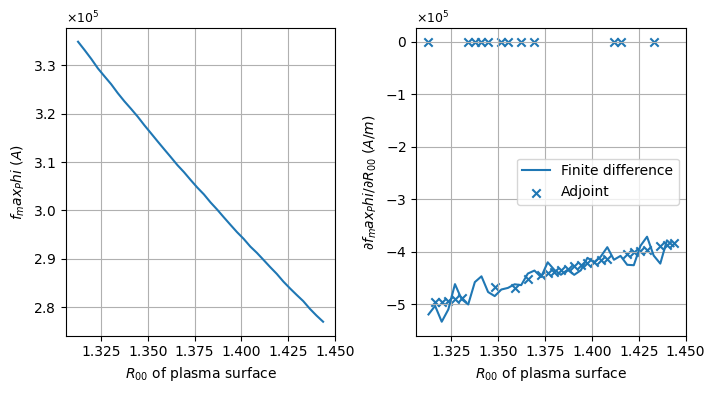

In [9]:
plot_taylor_test(
    plasma_dof_0_list_slack,
    stacked_outdict_slack, 
    metric='f_max_Phi',
    ylabel=r'$f_max_Phi$ ($A$)',
    dylabel=r'$\partial f_max_Phi/\partial R_{00}$ ($A/m$)',
    # filename=plot_dir + '/' + 'taylor_regcoil.pdf'
)

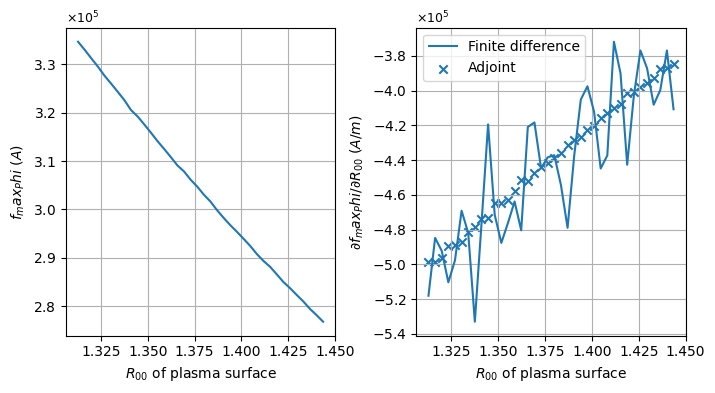

In [10]:
plot_taylor_test(
    plasma_dof_0_list_approx,
    stacked_outdict_approx, 
    metric='f_max_Phi',
    ylabel=r'$f_max_Phi$ ($A$)',
    dylabel=r'$\partial f_max_Phi/\partial R_{00}$ ($A/m$)',
    # filename=plot_dir + '/' + 'taylor_regcoil.pdf'
)

In [11]:
stacked_outdict_approx.keys()

dict_keys(['f_B', 'f_max_Phi'])